In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression

In [58]:
df = pd.read_csv('SeoulBikeData.csv', encoding = 'cp949')

In [59]:
df.drop(["Date", "Holiday", "Seasons"], axis = 1, inplace = True)

In [60]:
df.head()

Rented Bike Count  Hour  Temperature(캜)  Humidity(%)  Wind speed (m/s)  \
0                254     0            -5.2           37               2.2   
1                204     1            -5.5           38               0.8   
2                173     2            -6.0           39               1.0   
3                107     3            -6.2           40               0.9   
4                 78     4            -6.0           36               2.3   

   Visibility (10m)  Dew point temperature(캜)  Solar Radiation (MJ/m2)  \
0              2000                     -17.6                      0.0   
1              2000                     -17.6                      0.0   
2              2000                     -17.7                      0.0   
3              2000                     -17.6                      0.0   
4              2000                     -18.6                      0.0   

   Rainfall(mm)  Snowfall (cm) Functioning Day  
0           0.0            0.0             Yes  
1           0.0            0.0             Yes  
2           0.0            0.0             Yes  
3           0.0            0.0             Yes  
4           0.0            0.0             Yes

In [61]:
cols = ['bike_count', 'hour', 'temp', 'humidity', 'wind', 'visibility', 'dew_pt_temp', 'radiation', 'rain', 'snow', 'functional']

In [62]:
df.columns = cols

In [63]:
df.head()

bike_count  hour  temp  humidity  wind  visibility  dew_pt_temp  radiation  \
0         254     0  -5.2        37   2.2        2000        -17.6        0.0   
1         204     1  -5.5        38   0.8        2000        -17.6        0.0   
2         173     2  -6.0        39   1.0        2000        -17.7        0.0   
3         107     3  -6.2        40   0.9        2000        -17.6        0.0   
4          78     4  -6.0        36   2.3        2000        -18.6        0.0   

   rain  snow functional  
0   0.0   0.0        Yes  
1   0.0   0.0        Yes  
2   0.0   0.0        Yes  
3   0.0   0.0        Yes  
4   0.0   0.0        Yes

In [64]:
df["functional"] = (df.functional == 'Yes').astype(int)
df = df[df['hour'] == 12]
df = df.drop(['hour'], axis = 1)

In [65]:
df.head()

bike_count  temp  humidity  wind  visibility  dew_pt_temp  radiation  \
12          449   1.7        23   1.4        2000        -17.2       1.11   
36          479   4.3        41   1.3        1666         -7.8       1.09   
60          333   5.8        85   1.7         349          3.4       0.43   
84          393  -0.3        38   4.8        1823        -12.9       1.11   
108         321  -2.3        25   0.0        1962        -19.7       0.00   

     rain  snow  functional  
12    0.0   0.0           1  
36    0.0   0.0           1  
60    0.0   0.0           1  
84    0.0   0.0           1  
108   0.0   0.0           1

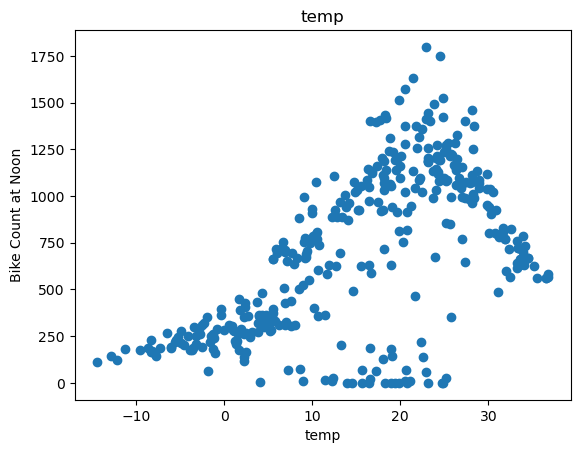

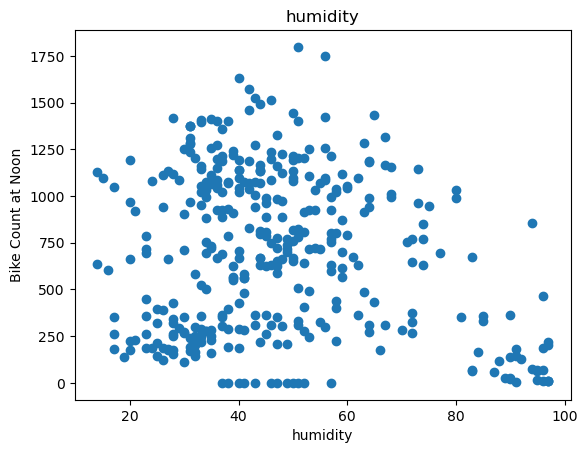

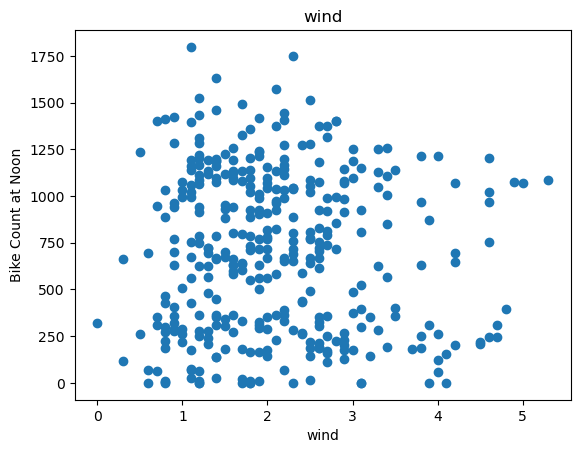

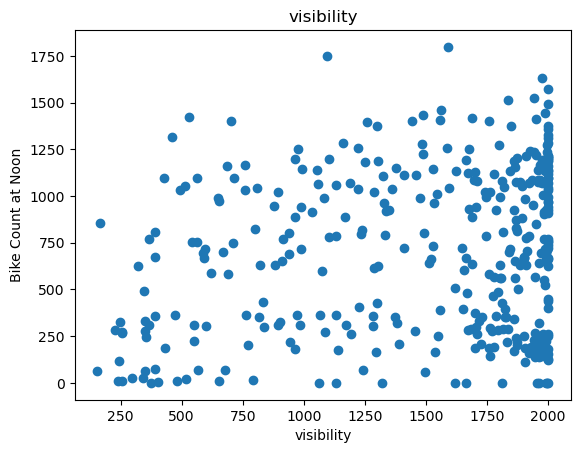

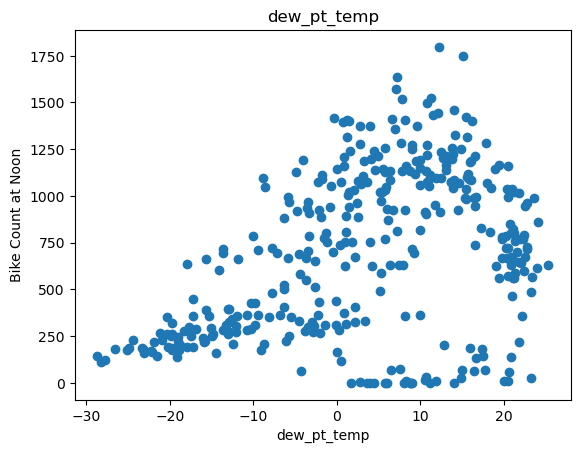

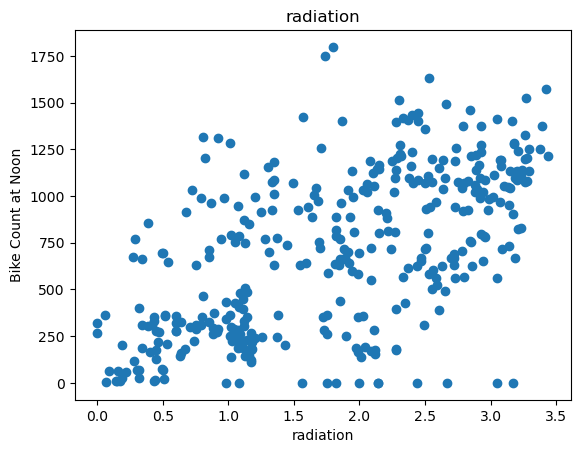

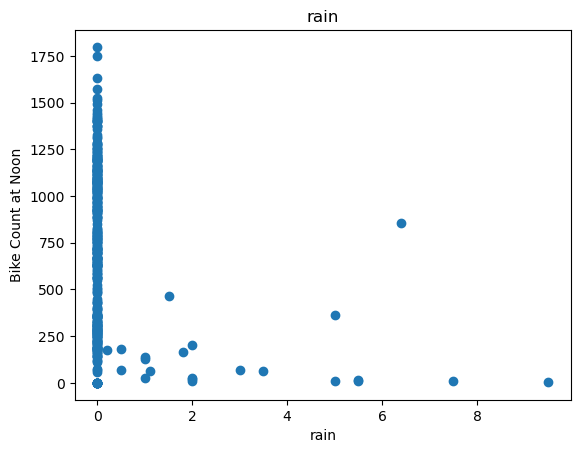

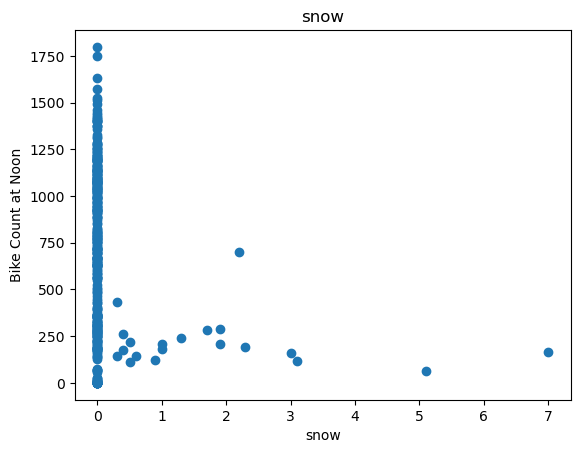

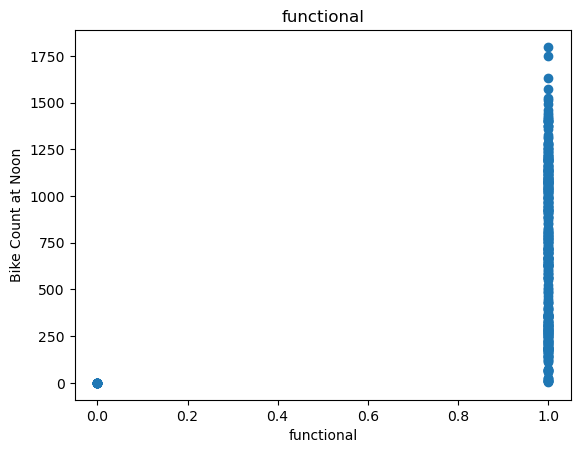

In [66]:
# for label in df.columns[1:]:
#     plt.scatter(df[label], df["bike_count"])
#     plt.title(label)
#     plt.ylabel("Bike Count at Noon")
#     plt.xlabel(label)
#     plt.show()

In [67]:
df = df.drop(["wind", "visibility", "functional"], axis = 1)

In [68]:
train, val, test = np.split(df.sample(frac = 1), [int(0.6*len(df)), int(0.8*len(df))])

In [75]:
def get_xy(dataframe, y_label, x_labels = None):
    dataframe = copy.deepcopy(dataframe)
    if x_labels is None:
        X = dataframe[[c for c in dataframe.columns if c != y_label]].values
    else:
        if len(x_labels) == 1:
            X = dataframe[x_labels[0]].values.reshape(-1, 1)
        
        else:
            X = dataframe[x_labels].values
    
    y = dataframe[y_label].values.reshape(-1, 1)
    data = np.hstack((X, y))
    
    return data, X, y

In [76]:
_, X_train_temp, y_train_temp = get_xy(train, 'bike_count', x_labels = ["temp"])
_, X_val_temp, y_val_temp = get_xy(val, 'bike_count', x_labels = ["temp"])
_, X_test_temp, y_test_temp = get_xy(test, 'bike_count', x_labels = ["temp"])

In [77]:
temp_reg = LinearRegression()
temp_reg.fit(X_train_temp, y_train_temp)

LinearRegression()

In [78]:
print(temp_reg.coef_, temp_reg.intercept_)

[[22.56104273]] [369.7814765]


In [79]:
temp_reg.score(X_test_temp, y_test_temp)

0.3360163879586535

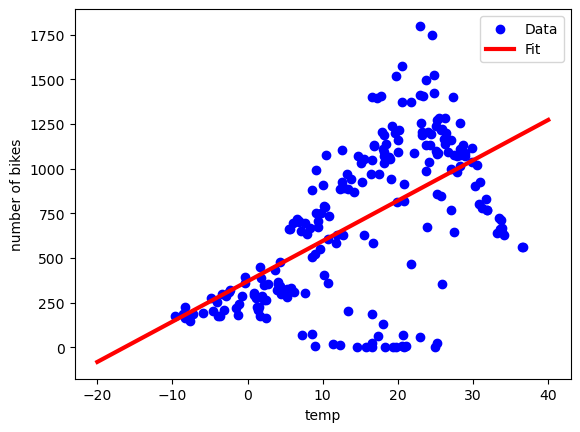

In [80]:
plt.scatter(X_train_temp, y_train_temp, label = "Data", color = 'blue')
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_reg.predict(np.reshape(x, (-1, 1))), label = 'Fit', color = 'red', linewidth = 3)
plt.legend()
plt.ylabel('number of bikes')
plt.xlabel('temp')
plt.show()

## Multiple Linear Regression

In [81]:
_, X_train_all, y_train_all = get_xy(train, 'bike_count', x_labels = df.columns[1:])
_, X_val_all, y_val_all = get_xy(val, 'bike_count', x_labels = df.columns[1:])
_, X_test_all, y_test_all = get_xy(test, 'bike_count', x_labels = df.columns[1:])

In [82]:
all_reg = LinearRegression()
all_reg.fit(X_train_all, y_train_all)

LinearRegression()

In [83]:
all_reg.score(X_test_all, y_test_all)

0.43624329860773015

## Regression with Neural Net

In [88]:
def plot_loss(history):
    plt.plot(history.history["loss"], label = 'loss')
    plt.plot(history.history['val_loss'], label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)
    plt.show()

In [84]:
temp_normalizer = tf.keras.layers.Normalization(input_shape = (1,), axis = None)
temp_normalizer.adapt(X_train_temp.reshape(-1, 1))

2022-11-26 13:09:03.153686: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-26 13:09:03.165756: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [85]:
temp_nn_model = tf.keras.Sequential([
    temp_normalizer, 
    tf.keras.layers.Dense(1)
])

In [86]:
temp_nn_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.1), loss = 'mean_squared_error')

In [87]:
history = temp_nn_model.fit(
    X_train_temp.reshape(-1), y_train_temp, verbose = 0, epochs = 1000, 
    validation_data = (X_val_temp, y_val_temp)
)

2022-11-26 13:09:06.481560: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-26 13:09:07.463499: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


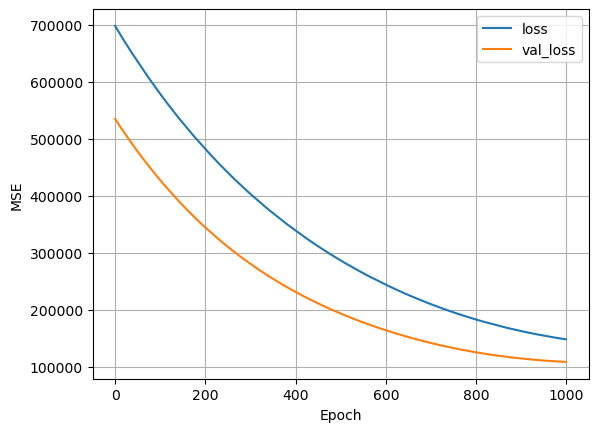

In [89]:
plot_loss(history)

4/4 [==============================] - 0s 3ms/step


2022-11-26 13:15:55.849369: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


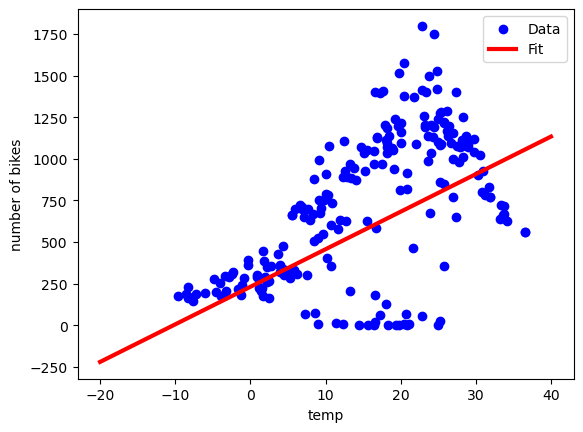

In [90]:
plt.scatter(X_train_temp, y_train_temp, label = "Data", color = 'blue')
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_nn_model.predict(np.reshape(x, (-1, 1))), label = 'Fit', color = 'red', linewidth = 3)
plt.legend()
plt.ylabel('number of bikes')
plt.xlabel('temp')
plt.show()

## Nueral Net

In [91]:
temp_normalizer = tf.keras.layers.Normalization(input_shape = (1,), axis = None)
temp_normalizer.adapt(X_train_temp.reshape(-1, 1))

nn_model = tf.keras.Sequential([
    temp_normalizer, 
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'relu')
])

nn_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_squared_error')

In [92]:
history = nn_model.fit(
    X_train_temp, y_train_temp, 
    validation_data = (X_val_temp, y_val_temp),
    verbose = 0, epochs = 100)

2022-11-26 13:20:01.876361: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-26 13:20:03.085617: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


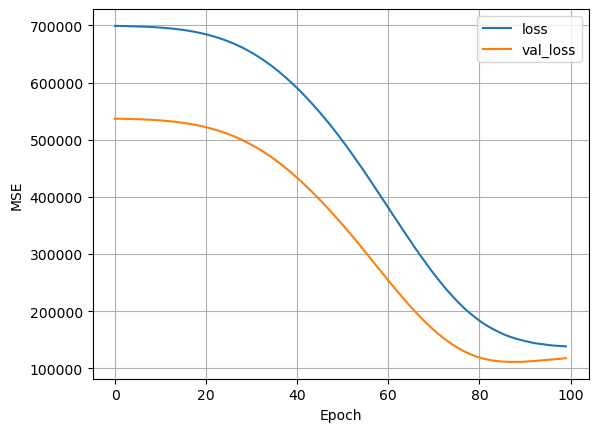

In [93]:
plot_loss(history)

4/4 [==============================] - 0s 48ms/step


2022-11-26 13:21:13.666923: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


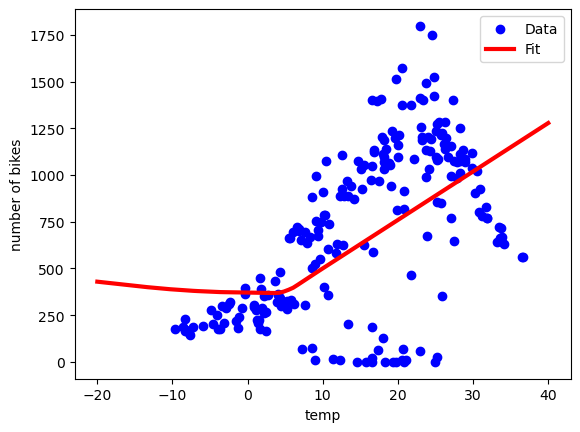

In [94]:
plt.scatter(X_train_temp, y_train_temp, label = "Data", color = 'blue')
x = tf.linspace(-20, 40, 100)
plt.plot(x, nn_model.predict(np.reshape(x, (-1, 1))), label = 'Fit', color = 'red', linewidth = 3)
plt.legend()
plt.ylabel('number of bikes')
plt.xlabel('temp')
plt.show()

In [99]:
all_normalizer = tf.keras.layers.Normalization(input_shape = (6,), axis = -1)
all_normalizer.adapt(X_train_all)

nn_model = tf.keras.Sequential([
    all_normalizer, 
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(1)
])

nn_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_squared_error')

2022-11-26 13:27:55.886353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-26 13:27:55.901257: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [100]:
history = nn_model.fit(
    X_train_all, y_train_all,
    validation_data = (X_val_all, y_val_all),
    verbose = 0, epochs = 100)

2022-11-26 13:27:56.802868: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-26 13:27:57.033669: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


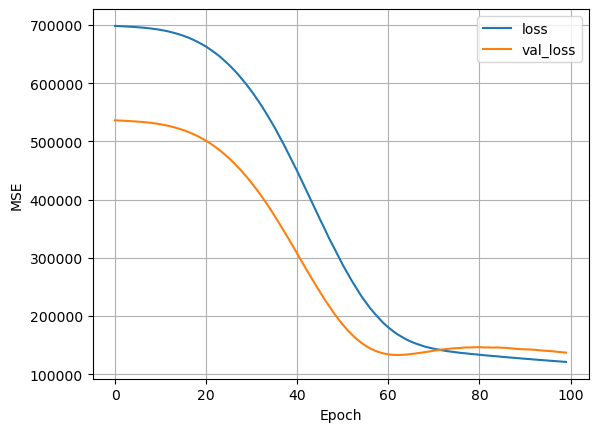

In [101]:
plot_loss(history)

In [102]:
y_pred_lr = all_reg.predict(X_test_all)
y_pred_nn = nn_model.predict(X_test_all)

3/3 [==============================] - 0s 8ms/step


2022-11-26 13:28:41.746004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [103]:
def MSE(y_pred, y_real):
    return (np.square(y_pred - y_real)).mean()

In [104]:
MSE(y_pred_lr, y_test_all)

103010.55522177307

In [105]:
MSE(y_pred_nn, y_test_all)

125287.11501941265

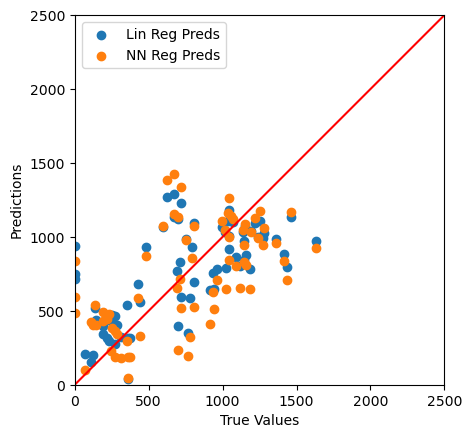

In [108]:
ax = plt.axes(aspect = 'equal')
plt.scatter(y_test_all, y_pred_lr, label = 'Lin Reg Preds')
plt.scatter(y_test_all, y_pred_nn, label = 'NN Reg Preds')
plt.xlabel("True Values")
plt.ylabel("Predictions")
lims = [0, 2500]
plt.xlim(lims)
plt.legend()
plt.ylim(lims)
_ = plt.plot(lims, lims, c= 'red')